# Red blood cell classifier : practical application of a convNet

With this example, you will build your own convNet in order to perform a specific task : classifying images of red blood cells (RBC) of either good or bad quality.

Data were kindly given by Viviana Claveria & Manouk Abkarian from the Centre of Biochimie Structurale. 

This notebook was inspired from the EMBL notebooks from the Kreshuk lab (https://github.com/kreshuklab/teaching-dl-course-2020/).

## I - Data importation

The data are RGB images saved in the png format on a google drive. All images are already sorted according to two classes :
- good RBC (1)
- bad RBC (0)


The first step is to load all the python packages we will use in the notebook:

In [ ]:
import os
from glob import glob
import random
import sys
import warnings
import numpy as np
from tqdm import tqdm

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt

If your data are save on your google drive, you first need to connect google drive to google collab and move to the folder containing the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

base_dir = '/content/gdrive/My Drive/Deep_learning_formation_MRI/Doc_JB_2021/Divers_part2/RBC_database/'
os.chdir(base_dir)
%ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
test/  train/  validation/


Since all the images are different and do not have the same X,Y dimensions we will define a set of parameters to homogeneize the training/testing sets. For example, below the width and height of all images will be set to IMG_WIDTH and IMG_HEIGHT respectively. In our case, we are working with RGB images, the number of channels is therefore set to 3.

Note that **the path to the different folders will need to be updated** accordingly.

In [ ]:
# Set the image size
# -----------------
IMG_WIDTH = 70
IMG_HEIGHT = 70
IMG_CHANNEL = 3

# Define the path where the data are saved
# ----------------------------------------

goodRBC_train_PATH = '/content/gdrive/My Drive/Deep_learning_formation_MRI/Doc_JB_2021/Divers_part2/RBC_database/train/goodRBC/'
badRBC_train_PATH = '/content/gdrive/My Drive/Deep_learning_formation_MRI/Doc_JB_2021/Divers_part2/RBC_database/train/badRBC/'

goodRBC_val_PATH = '/content/gdrive/My Drive/Deep_learning_formation_MRI/Doc_JB_2021/Divers_part2/RBC_database/validation/goodRBC/'
badRBC_val_PATH = '/content/gdrive/My Drive/Deep_learning_formation_MRI/Doc_JB_2021/Divers_part2/RBC_database/validation/badRBC/'

goodRBC_test_PATH = '/content/gdrive/My Drive/Deep_learning_formation_MRI/Doc_JB_2021/Divers_part2/RBC_database/test/goodRBC/'
badRBC_test_PATH = '/content/gdrive/My Drive/Deep_learning_formation_MRI/Doc_JB_2021/Divers_part2/RBC_database/test/badRBC/'

The following method **get_data** is used to download the images and convert them to the right format (according to the parameters defined above).

In [ ]:
def get_data(path):
  # get the total number of samples
  ids = next(os.walk(path))[2]
  X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)

  sys.stdout.flush()

  for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    path_new = path + id_

    # we'll be using skimage library for reading file and make sure all the images
    # have the same dimensions
    img = imread(path_new)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    if len(img.shape) == 3:
      X[n] = img
    else:
      img = np.stack((img,)*3, axis=-1)
      X[n] = img

  return X

The training and testing set are defined below. The ground truth is designed in parallel. 
Note that it takes ~20-30min to download the data. 

In [ ]:
Good_RBC = get_data(goodRBC_train_PATH)
y_good = np.ones((Good_RBC.shape[0],))
Bad_RBC = get_data(badRBC_train_PATH)
y_bad = np.zeros((Bad_RBC.shape[0],))

X_train = np.concatenate((Good_RBC,Bad_RBC), axis=0)
Y_train = np.concatenate((y_good,y_bad), axis=0)


Good_RBC_test = get_data(goodRBC_test_PATH)
y_good = np.ones((Good_RBC_test.shape[0],))
Bad_RBC_test = get_data(badRBC_test_PATH)
y_bad = np.zeros((Bad_RBC_test.shape[0],))

X_test = np.concatenate((Good_RBC_test,Bad_RBC_test), axis=0)
Y_test = np.concatenate((y_good,y_bad), axis=0)


100%|██████████| 667/667 [00:03<00:00, 181.87it/s]


Return the composition of the dataset

In [ ]:
print('The train dataset is composed of {} images belonging to the "goodRBC" class and {} images belonging to the "badRBC" class'.format(Good_RBC.shape[0],Bad_RBC.shape[0]))
print('The test dataset is composed of {} images belonging to the "goodRBC" class and {} images belonging to the "badRBC" class'.format(Good_RBC_test.shape[0],Bad_RBC_test.shape[0]))

The train dataset is composed of 956 images belonging to the "goodRBC" class and 1844 images belonging to the "badRBC" class
The test dataset is composed of 319 images belonging to the "goodRBC" class and 667 images belonging to the "badRBC" class


And finally make sure the data are normalized : 

In [ ]:
X_train = X_train/255
X_test = X_test/255

## II- Data vizualization :

Display a few examples of images belonging to the "GoodRBC" class

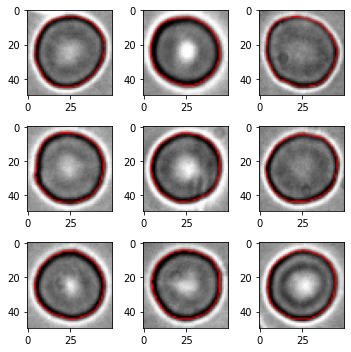

In [ ]:
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(Good_RBC))
    im = Good_RBC[num]
    plt.imshow(im)
    
plt.tight_layout()

And the same for the "BadRBC" class

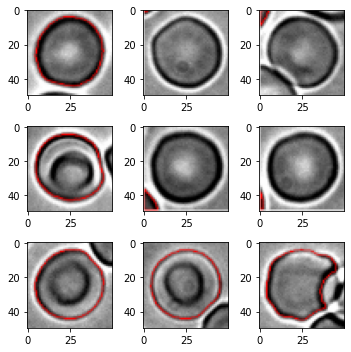

In [ ]:
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(Bad_RBC))
    im = Bad_RBC[num]
    plt.imshow(im)
    
plt.tight_layout()

## III- Definition of the model and training

Define the model and the compilation options. 


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50,50,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         1

Define the model and the compilation options. 

In [ ]:
history = model.fit(X_train, Y_train,
                    batch_size = 32,
                    epochs = 25,
                    validation_data=(X_test, Y_test),
                    shuffle = True)

Epoch 1/25
88/88 [==============================] - 15s 158ms/step - loss: 0.6230 - accuracy: 0.6365 - val_loss: 0.5095 - val_accuracy: 0.6592
Epoch 2/25
88/88 [==============================] - 14s 155ms/step - loss: 0.4827 - accuracy: 0.6850 - val_loss: 0.4805 - val_accuracy: 0.6785
Epoch 3/25
88/88 [==============================] - 13s 152ms/step - loss: 0.4600 - accuracy: 0.7393 - val_loss: 0.4077 - val_accuracy: 0.7688
Epoch 4/25
88/88 [==============================] - 13s 152ms/step - loss: 0.3988 - accuracy: 0.7891 - val_loss: 0.3585 - val_accuracy: 0.8032
Epoch 5/25
88/88 [==============================] - 13s 153ms/step - loss: 0.3474 - accuracy: 0.8260 - val_loss: 0.3521 - val_accuracy: 0.8124
Epoch 6/25
88/88 [==============================] - 13s 154ms/step - loss: 0.3405 - accuracy: 0.8425 - val_loss: 0.3455 - val_accuracy: 0.8225
Epoch 7/25
88/88 [==============================] - 13s 152ms/step - loss: 0.3245 - accuracy: 0.8460 - val_loss: 0.3544 - val_accuracy: 0.8316

Display the loss function during the training


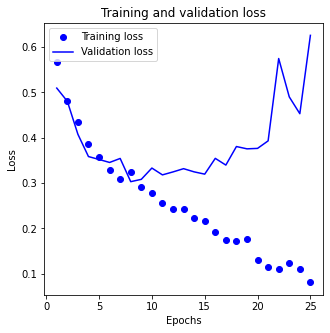

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

n = len(loss_values)
epochs = range(1, n+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The accuracy of the model is tested using the testing set of data.

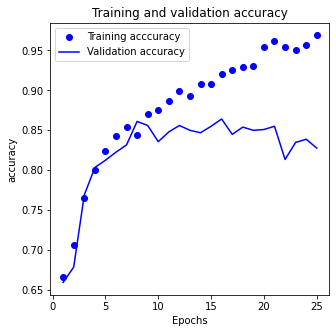

In [ ]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

n = len(acc_values)
epochs = range(1, n+1)

plt.plot(epochs, acc_values, 'bo', label='Training acccuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## IV- Transfer learning

In the following section, we will see how transfer learning can be used to improve the performances of a classifier. The idea is to  used a previously trained network (such as VGG16) that was already trained on thousands of images and able to recognize hundred of thousands of different features on images.

By adding new layers at the end of the pre-trained network, we can use the features recognition property of this network and applied it to a completely new problem. 

The first step is to load the pre-trained VGG16 network. There are many different available model in keras (https://keras.io/api/applications/).

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top = False,input_shape=(50,50,3))

58892288/58889256 [==============================] - 0s 0us/step


And then we will build our model around the VGG16 :

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

We need to define which part of the network will be trained. In our case, only the last convolution block of the VGG and the densely connected part will be trained :

In [ ]:
conv_base.trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if layer.name == 'block5_conv2':
        set_trainable = True
    if layer.name == 'block5_conv3':
        set_trainable = True 
            
model.compile(optimizer = 'adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

And finally train the new model and save it.

In [ ]:
history = model.fit(X_train, Y_train,
                    batch_size = 64,
                    epochs = 25,
                    validation_data=(X_test, Y_test),
                    shuffle = True)


# Save the model
# --------------

model.save('RBC_classification_VGG16_1.h5')

Epoch 1/25
88/88 [==============================] - 93s 1s/step - loss: 0.6376 - accuracy: 0.6464 - val_loss: 0.4573 - val_accuracy: 0.7677
Epoch 2/25
88/88 [==============================] - 91s 1s/step - loss: 0.4612 - accuracy: 0.7702 - val_loss: 0.4051 - val_accuracy: 0.7941
Epoch 3/25
88/88 [==============================] - 91s 1s/step - loss: 0.4280 - accuracy: 0.7726 - val_loss: 0.3567 - val_accuracy: 0.8357
Epoch 4/25
88/88 [==============================] - 92s 1s/step - loss: 0.4106 - accuracy: 0.8037 - val_loss: 0.3554 - val_accuracy: 0.8266
Epoch 5/25
88/88 [==============================] - 92s 1s/step - loss: 0.3771 - accuracy: 0.8227 - val_loss: 0.3335 - val_accuracy: 0.8671
Epoch 6/25
88/88 [==============================] - 92s 1s/step - loss: 0.3719 - accuracy: 0.8258 - val_loss: 0.3341 - val_accuracy: 0.8671
Epoch 7/25
88/88 [==============================] - 92s 1s/step - loss: 0.3930 - accuracy: 0.8164 - val_loss: 0.3272 - val_accuracy: 0.8651
Epoch 8/25
88/88 [==

KeyboardInterrupt: ignored